In [1]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import shared

ve_or_ju = "ve"
year = 2019

In [2]:
estimates = pd.read_json(f'web-lib/for_web_{ve_or_ju}_{year}.json', orient="records", convert_dates=["fin_time_median", "fin_time_start95", "fin_time_end95"])



In [3]:
estimates.head()

,dark_during_leg,fin_sum_log_mean,fin_sum_log_std,fin_time_end95,fin_time_median,fin_time_start95,ind_log_mean,ind_log_std,leg,mass_start,name,num_runs,personal_end95,personal_median,personal_start95,team,team_id
0,0,3.677645,0.067824,2019-06-15 11:45:11.347,2019-06-15 11:39:33.079,2019-06-15 11:34:41.518,1.8857,0.067659,1,0.0,Tilda Östberg,1,45.189117,39.551333,34.691978,Stora Tuna OK 1,1
1,0,4.381138,0.055759,2019-06-15 12:29:13.357,2019-06-15 12:19:52.374,2019-06-15 12:11:37.067,1.9556,0.088600,2,0.0,Magdalena Olsson,6,47.901834,40.257489,33.909699,Stora Tuna OK 1,1
2,0,4.816543,0.053067,2019-06-15 13:17:08.671,2019-06-15 13:03:26.878,2019-06-15 12:51:26.356,1.7824,0.110076,3,0.0,Julia Jakob,1,54.051577,43.441498,35.048827,Stora Tuna OK 1,1
3,0,5.145269,0.042697,2019-06-15 14:06:33.296,2019-06-15 13:51:35.440,2019-06-15 13:37:54.397,1.8027,0.067659,4,0.0,Tove Alexandersson,6,54.694844,47.948494,42.044603,Stora Tuna OK 1,1
4,0,3.796847,0.077894,2019-06-15 11:51:58.615,2019-06-15 11:44:33.646,2019-06-15 11:38:15.705,2.0053,0.077564,1,0.0,Amanda Hansson,2,51.976932,44.560778,38.261758,Göteborg Majorna OK 1,2


In [4]:
display(estimates.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6728 entries, 0 to 6727
Data columns (total 17 columns):
dark_during_leg     6728 non-null int64
fin_sum_log_mean    6728 non-null float64
fin_sum_log_std     6728 non-null float64
fin_time_end95      6728 non-null datetime64[ns]
fin_time_median     6728 non-null datetime64[ns]
fin_time_start95    6728 non-null datetime64[ns]
ind_log_mean        6728 non-null float64
ind_log_std         6728 non-null float64
leg                 6728 non-null int64
mass_start          6728 non-null float64
name                6728 non-null object
num_runs            6728 non-null int64
personal_end95      6728 non-null float64
personal_median     6728 non-null float64
personal_start95    6728 non-null float64
team                6728 non-null object
team_id             6728 non-null int64
dtypes: datetime64[ns](3), float64(8), int64(4), object(2)
memory usage: 893.6+ KB


None

In [5]:
# Read the actual times after race and analyze estimates

results = pd.read_csv(f'data/results_with_dist_j{year}_{ve_or_ju}.tsv', delimiter="\t")
display(results.head().round(2))
results = results[["team-id", "leg-nro", "leg-time", "leg_distance"]]
results["leg-time"] = results["leg-time"] / 60
results = results.rename(index=str, columns={"team-id": "team_id", "leg-nro": "leg"})
results.head()

,team-id,placement,team-time,team-name,team-nro,leg-nro,emit,leg-time,competitor-name,weighted_log_mean_pace,weighted_log_pace_std,disqualified,leg_distance
0,22,1.0,9917.0,Fredrikstad SK,1,1,1237786.0,2325.0,Marianne Riddervold Kahrs,1.85,0.25,False,6.0
1,22,1.0,9917.0,Fredrikstad SK,1,2,1509400.0,2136.0,Marie Olaussen,1.83,0.25,False,5.7
2,22,1.0,9917.0,Fredrikstad SK,1,3,1509422.0,2595.0,Marianne Andersen,1.77,0.19,False,7.3
3,22,1.0,9917.0,Fredrikstad SK,1,4,1509399.0,2860.0,Kamilla Olaussen,1.78,0.22,False,7.9
4,19,2.0,10138.0,IFK Göteborg,1,1,1217441.0,2314.0,Miri Thrane Ödum,1.83,0.26,False,6.0


,team_id,leg,leg-time,leg_distance
0,22,1,38.750000,6.0
1,22,2,35.600000,5.7
2,22,3,43.250000,7.3
3,22,4,47.666667,7.9
4,19,1,38.566667,6.0


In [6]:

with_result = pd.merge(estimates, results, how='left', on=['team_id', 'leg'])
with_result = with_result[np.isfinite(with_result["leg-time"])]

In [7]:
with_result.head()


,dark_during_leg,fin_sum_log_mean,fin_sum_log_std,fin_time_end95,fin_time_median,fin_time_start95,ind_log_mean,ind_log_std,leg,mass_start,name,num_runs,personal_end95,personal_median,personal_start95,team,team_id,leg-time,leg_distance
0,0,3.677645,0.067824,2019-06-15 11:45:11.347,2019-06-15 11:39:33.079,2019-06-15 11:34:41.518,1.8857,0.067659,1,0.0,Tilda Östberg,1,45.189117,39.551333,34.691978,Stora Tuna OK 1,1,47.416667,6.0
1,0,4.381138,0.055759,2019-06-15 12:29:13.357,2019-06-15 12:19:52.374,2019-06-15 12:11:37.067,1.9556,0.088600,2,0.0,Magdalena Olsson,6,47.901834,40.257489,33.909699,Stora Tuna OK 1,1,37.050000,5.7
2,0,4.816543,0.053067,2019-06-15 13:17:08.671,2019-06-15 13:03:26.878,2019-06-15 12:51:26.356,1.7824,0.110076,3,0.0,Julia Jakob,1,54.051577,43.441498,35.048827,Stora Tuna OK 1,1,44.116667,7.3
3,0,5.145269,0.042697,2019-06-15 14:06:33.296,2019-06-15 13:51:35.440,2019-06-15 13:37:54.397,1.8027,0.067659,4,0.0,Tove Alexandersson,6,54.694844,47.948494,42.044603,Stora Tuna OK 1,1,46.200000,7.9
4,0,3.796847,0.077894,2019-06-15 11:51:58.615,2019-06-15 11:44:33.646,2019-06-15 11:38:15.705,2.0053,0.077564,1,0.0,Amanda Hansson,2,51.976932,44.560778,38.261758,Göteborg Majorna OK 1,2,40.483333,6.0


In [8]:
with_result["ind_leg_time_estimate"] = np.exp(with_result["ind_log_mean"]) * with_result["leg_distance"]

In [9]:
with_result["ind_error"] = np.abs(with_result["ind_leg_time_estimate"] - with_result["leg-time"])
with_result["ind_error_ratio"] = with_result["ind_error"] / with_result["leg-time"]
with_result["ind_interval_error"] = (with_result["personal_start95"] > with_result["leg-time"]) | (with_result["personal_end95"] < with_result["leg-time"])


In [10]:
with_result.sort_values(by=['ind_error']).tail(10).round(2)

,dark_during_leg,fin_sum_log_mean,fin_sum_log_std,fin_time_end95,fin_time_median,fin_time_start95,ind_log_mean,ind_log_std,leg,mass_start,...,personal_median,personal_start95,team,team_id,leg-time,leg_distance,ind_leg_time_estimate,ind_error,ind_error_ratio,ind_interval_error
6535,0,5.99,0.09,2019-06-15 18:59:02.242,2019-06-15 17:40:16.537,2019-06-15 16:35:00.886,2.71,0.18,4,0.64,...,118.03,83.59,Team Persikka 1,1671,201.98,7.9,118.50,83.48,0.41,True
5796,0,4.32,0.18,2019-06-15 12:47:14.660,2019-06-15 12:15:29.228,2019-06-15 11:52:48.127,2.53,0.18,1,0.00,...,75.49,52.80,Jyväskylän amk 2,1483,160.55,6.0,75.34,85.21,0.53,True
4211,0,5.90,0.08,2019-06-15 18:09:11.793,2019-06-15 17:05:29.561,2019-06-15 16:12:46.173,2.74,0.16,4,0.11,...,122.21,90.06,Rasti-Perniö 2,1072,211.48,7.9,122.37,89.11,0.42,True
6260,0,4.28,0.20,2019-06-15 12:46:19.071,2019-06-15 12:12:20.992,2019-06-15 11:48:55.965,2.49,0.20,1,0.00,...,72.35,48.93,Ota kiinni jos saat 1,1602,164.88,6.0,72.14,92.75,0.56,True
5889,0,5.18,0.13,2019-06-15 14:48:28.607,2019-06-15 13:57:16.329,2019-06-15 13:17:23.202,2.71,0.18,2,0.00,...,85.49,59.82,Ukkoskyykky 1,1507,183.43,5.7,85.50,97.93,0.53,True
6433,0,5.18,0.13,2019-06-15 14:48:03.536,2019-06-15 13:56:39.073,2019-06-15 13:17:12.096,2.71,0.18,2,0.00,...,85.53,59.72,Harharetki 1,1646,187.03,5.7,85.50,101.53,0.54,True
5811,0,5.90,0.11,2019-06-15 18:30:19.932,2019-06-15 17:04:55.590,2019-06-15 15:54:42.918,2.46,0.21,4,0.51,...,92.32,61.15,Paha rasti - etsikää meidät ennen pimeää 2,1486,195.40,7.9,92.58,102.82,0.53,True
4774,0,5.54,0.14,2019-06-15 16:34:24.278,2019-06-15 15:13:35.387,2019-06-15 14:11:59.929,2.51,0.24,3,0.00,...,89.97,56.61,Hiukkasen Hukassa 1,1219,193.93,7.3,90.15,103.78,0.54,True
5621,0,5.24,0.09,2019-06-15 14:47:32.302,2019-06-15 14:08:44.595,2019-06-15 13:39:10.761,2.89,0.16,2,0.00,...,102.55,75.33,Valiokerho Jyväskylä 1,1438,212.15,5.7,102.60,109.55,0.52,True
6158,0,5.59,0.11,2019-06-15 16:34:17.174,2019-06-15 15:27:09.094,2019-06-15 14:33:13.627,2.40,0.19,3,0.00,...,80.40,55.65,Basware 1,1576,205.63,7.3,80.14,125.50,0.61,True


In [11]:
display(f'Yksilöennusteen keskivirhe: {np.mean(with_result["ind_error"]).round(1)} minuuttia')  

'Yksilöennusteen keskivirhe: 9.47 minuuttia'

In [44]:
display(f'Yksilöennusteen mediaanivirhe: {np.median(with_result["ind_error"]).round(1)} minuuttia') 

'Yksilöennusteen mediaanivirhe: 6.5 minuuttia'

In [13]:
display(f'Yksilön aikaväliennuste väärin: {np.mean(with_result["ind_interval_error"]).round(3) * 100} %')  

'Yksilön aikaväliennuste väärin: 5.8999999999999995 %'

In [14]:
with_result[["num_runs", 'ind_error', 'ind_interval_error']].groupby('num_runs').agg(["mean", "median", "count"]).round(2)

ind_error              ind_interval_error             
              mean median count               mean median count
num_runs                                                       
0            14.07  10.73  1611               0.07  False  1611
1            10.37   6.93  1011               0.07  False  1011
2             9.62   7.27   766               0.04  False   766
3             8.53   6.67   704               0.03  False   704
4             7.39   5.73   590               0.09  False   590
5             6.68   4.79   701               0.07  False   701
6             5.80   4.23   723               0.04  False   723
7             5.38   3.69   480               0.04  False   480
8             6.66   6.66     2               0.00  False     2
9             3.09   3.09     1               0.00  False     1

In [15]:
with_result[["leg", 'ind_error', 'ind_interval_error']].groupby('leg').agg(["mean", "median", "count"]).round(2)

ind_error              ind_interval_error             
         mean median count               mean median count
leg                                                       
1        8.15   5.74  1673               0.06  False  1673
2        8.75   5.81  1654               0.06  False  1654
3       10.69   7.26  1641               0.07  False  1641
4       10.31   7.43  1621               0.05  False  1621

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// # To disable auto-scrolling, execute this javascript in a notebook cell before other cells are executed:

<IPython.core.display.Javascript object>

(0, 100)

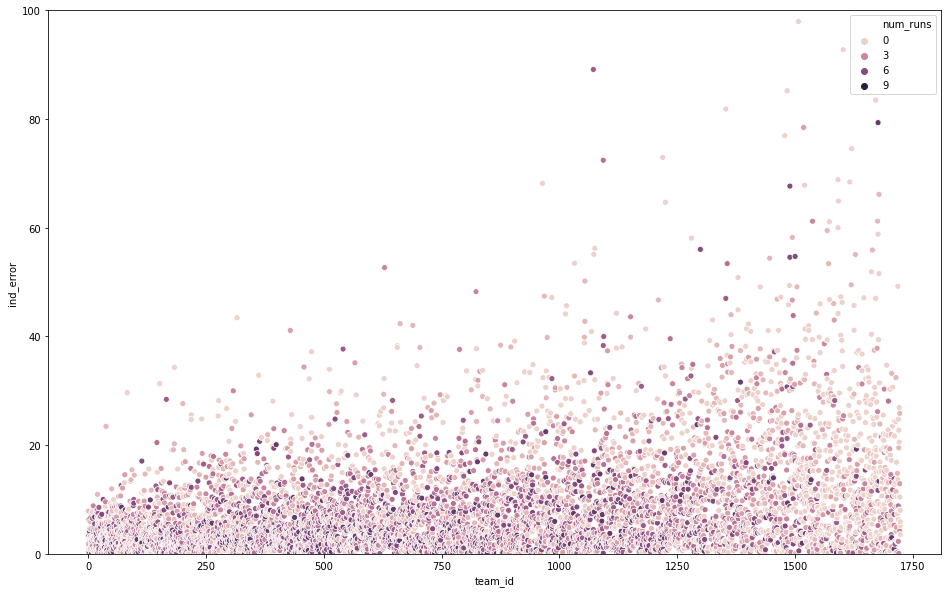

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="team_id", y="ind_error", hue="num_runs", data=with_result)
plot.axes.set_ylim(0, 100)


(30, 150)

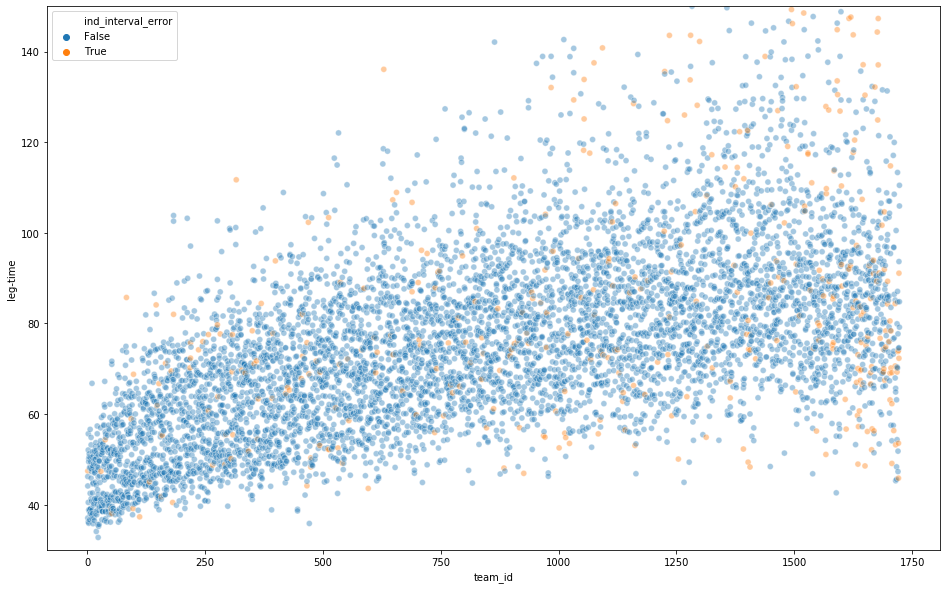

In [24]:
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="team_id", y="leg-time", hue="ind_interval_error", alpha=0.4, data=with_result)
plot.axes.set_ylim(30, 150)

(30, 150)

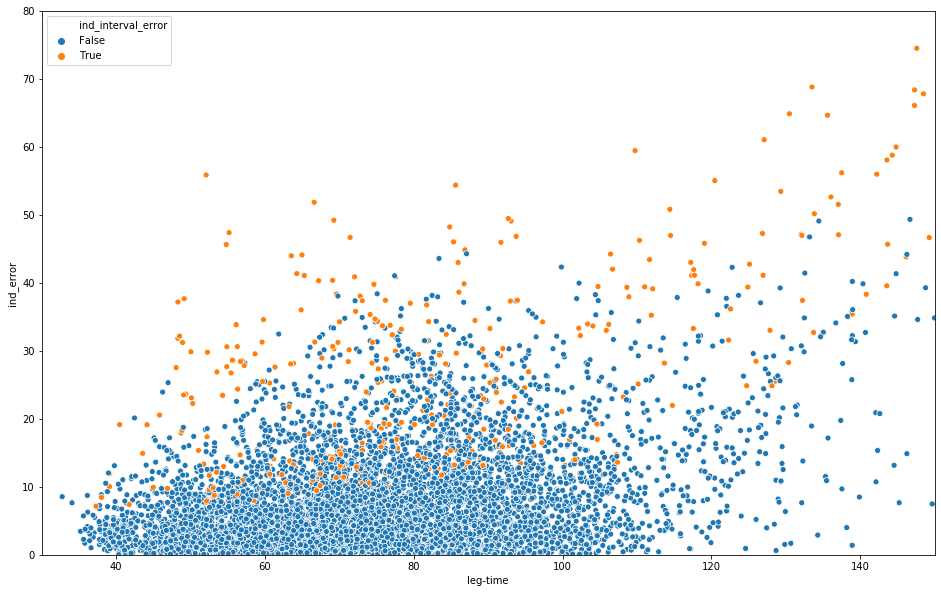

In [26]:
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="leg-time", y="ind_error", hue="ind_interval_error", data=with_result)
plot.axes.set_ylim(0, 80)
plot.axes.set_xlim(30, 150)

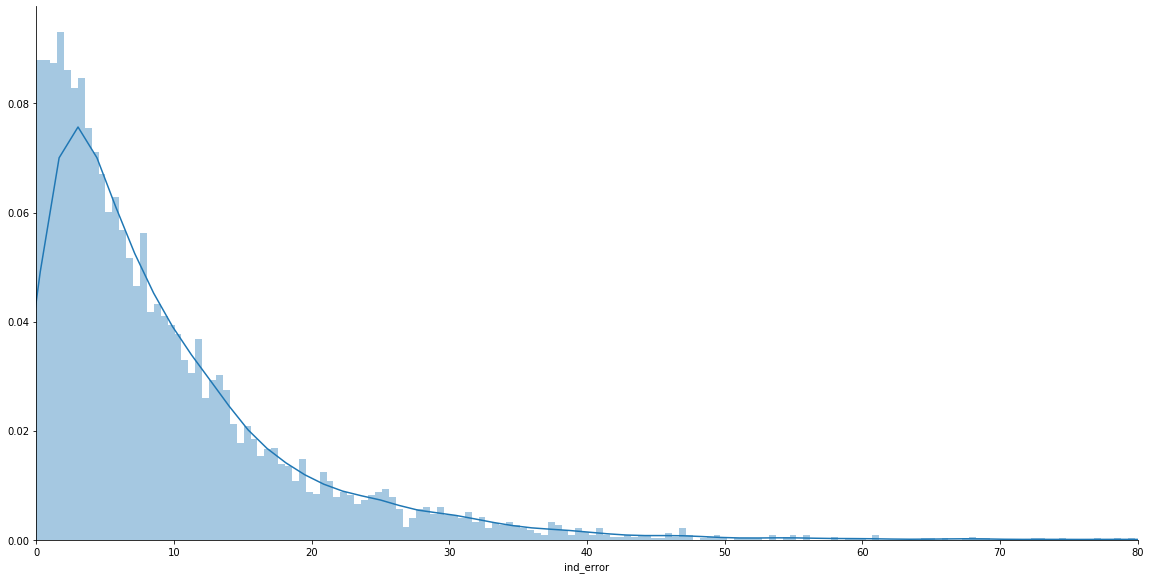

In [20]:
g = sns.FacetGrid(with_result, height=8, aspect=2, xlim=(0,80), margin_titles=True, despine=True)
#g.map(sns.distplot, "ind_error", hist_kws={'alpha':0.8}).add_legend()
sns.distplot(with_result.ind_error, bins=250, kde=True)

ValueError: `dataset` input should have multiple elements.

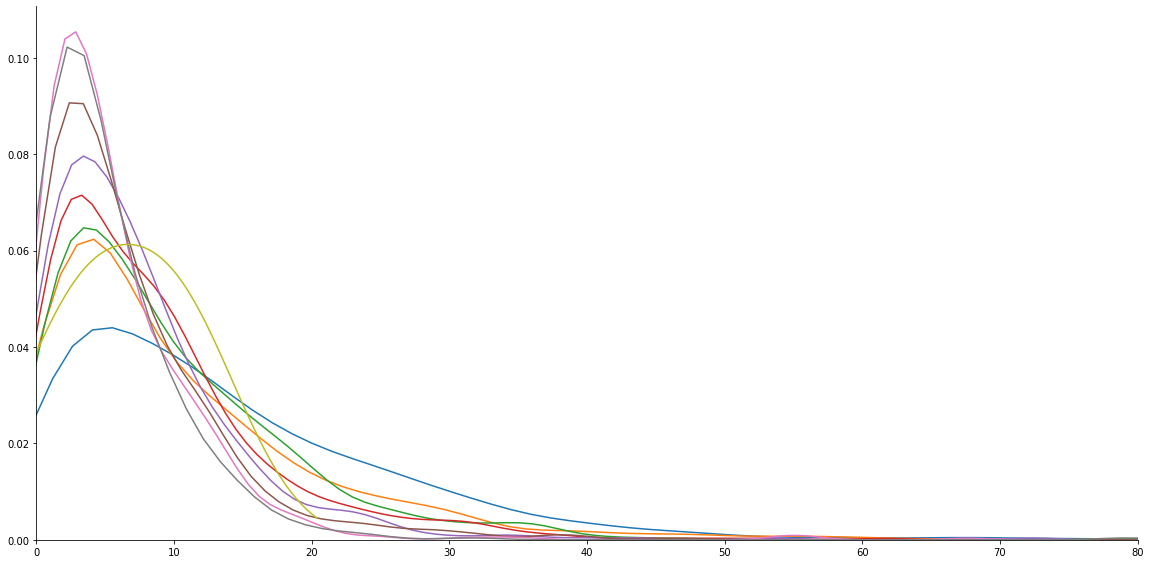

In [27]:
g = sns.FacetGrid(with_result, hue="num_runs", height=8, aspect=2, xlim=(0,80), margin_titles=True, despine=True)
g.map(sns.distplot, "ind_error", hist=False, hist_kws={'alpha':0.8}).add_legend()

In [28]:
def calculate_relay_values(result_row):
    rows_so_far = with_result[(with_result.team_id == result_row.team_id) & (with_result["leg"] <= result_row["leg"])]

    return pd.Series({"real_relay_time": np.sum(rows_so_far["leg-time"]), "mean_num_runs": np.mean(rows_so_far["num_runs"]).round(0)})

relay_values = with_result.apply(lambda row: calculate_relay_values(row), axis=1)

with_result["real_relay_time"] = relay_values["real_relay_time"]
with_result["mean_num_runs"] = relay_values["mean_num_runs"]
with_result.head(10)


,dark_during_leg,fin_sum_log_mean,fin_sum_log_std,fin_time_end95,fin_time_median,fin_time_start95,ind_log_mean,ind_log_std,leg,mass_start,...,team,team_id,leg-time,leg_distance,ind_leg_time_estimate,ind_error,ind_error_ratio,ind_interval_error,real_relay_time,mean_num_runs
0,0,3.677645,0.067824,2019-06-15 11:45:11.347,2019-06-15 11:39:33.079,2019-06-15 11:34:41.518,1.8857,0.067659,1,0.0,...,Stora Tuna OK 1,1,47.416667,6.0,39.545799,7.870868,0.165994,True,47.416667,1.0
1,0,4.381138,0.055759,2019-06-15 12:29:13.357,2019-06-15 12:19:52.374,2019-06-15 12:11:37.067,1.9556,0.088600,2,0.0,...,Stora Tuna OK 1,1,37.050000,5.7,40.288504,3.238504,0.087409,False,84.466667,4.0
2,0,4.816543,0.053067,2019-06-15 13:17:08.671,2019-06-15 13:03:26.878,2019-06-15 12:51:26.356,1.7824,0.110076,3,0.0,...,Stora Tuna OK 1,1,44.116667,7.3,43.391968,0.724699,0.016427,False,128.583333,3.0
3,0,5.145269,0.042697,2019-06-15 14:06:33.296,2019-06-15 13:51:35.440,2019-06-15 13:37:54.397,1.8027,0.067659,4,0.0,...,Stora Tuna OK 1,1,46.200000,7.9,47.921428,1.721428,0.037260,False,174.783333,4.0
4,0,3.796847,0.077894,2019-06-15 11:51:58.615,2019-06-15 11:44:33.646,2019-06-15 11:38:15.705,2.0053,0.077564,1,0.0,...,Göteborg Majorna OK 1,2,40.483333,6.0,44.569932,4.086599,0.100945,False,40.483333,2.0
5,0,4.467908,0.059292,2019-06-15 12:37:43.553,2019-06-15 12:27:13.243,2019-06-15 12:17:42.261,2.0081,0.087900,2,0.0,...,Göteborg Majorna OK 1,2,36.183333,5.7,42.460158,6.276825,0.173473,False,76.666667,4.0
6,0,4.934676,0.045345,2019-06-15 13:32:15.597,2019-06-15 13:19:02.544,2019-06-15 13:07:23.347,1.9581,0.067659,3,0.0,...,Göteborg Majorna OK 1,2,52.050000,7.3,51.726713,0.323287,0.006211,False,128.716667,4.0
7,0,5.282110,0.042899,2019-06-15 14:34:20.254,2019-06-15 14:16:48.004,2019-06-15 14:01:00.568,1.9854,0.097276,4,0.0,...,Göteborg Majorna OK 1,2,55.633333,7.9,57.527481,1.894147,0.034047,False,184.350000,4.0
8,0,3.682233,0.067719,2019-06-15 11:45:22.221,2019-06-15 11:39:44.543,2019-06-15 11:34:43.617,1.8899,0.067659,1,0.0,...,MS Parma 1,3,38.816667,6.0,39.712241,0.895574,0.023072,False,38.816667,4.0
9,0,4.376837,0.063766,2019-06-15 12:30:34.546,2019-06-15 12:19:29.692,2019-06-15 12:10:16.928,1.9401,0.108600,2,0.0,...,MS Parma 1,3,35.883333,5.7,39.668847,3.785514,0.105495,False,74.700000,5.0


In [29]:
with_result["relay_error"] = np.abs(np.exp(with_result["fin_sum_log_mean"]) - with_result["real_relay_time"])
with_result["relay_error_ratio"] = with_result["relay_error"] / with_result["real_relay_time"]

In [30]:
display(np.mean(with_result["relay_error"]))
display(np.mean(with_result["relay_error_ratio"]))

16.993463607976015

0.09698838224897458

In [31]:
display(f'Viestiennusteen keskivirhe: {np.mean(with_result["relay_error"]).round(1)} minuuttia')  
display(f'Viestiennusteen virheen mediaani: {np.median(with_result["relay_error"]).round(1)} minuuttia')  

'Viestiennusteen keskivirhe: 17.0 minuuttia'

'Viestiennusteen virheen mediaani: 10.6 minuuttia'

In [32]:
with_result[["leg", 'relay_error']].groupby('leg').agg(["mean", "median"]).round(2)

relay_error       
           mean median
leg                   
1          8.15   5.73
2         13.78   9.70
3         20.36  14.18
4         25.99  18.12

(0, 250)

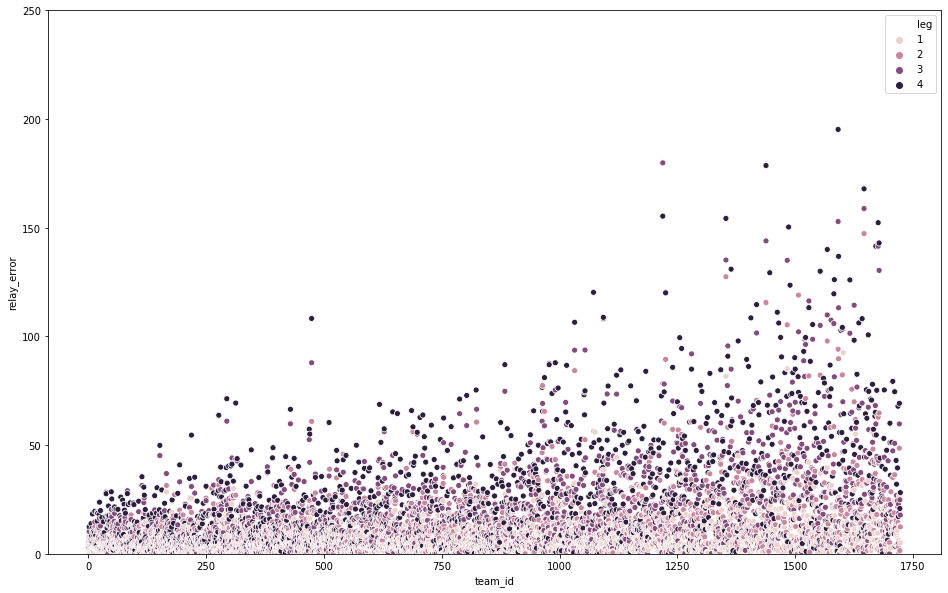

In [33]:
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="team_id", y="relay_error", hue="leg", data=with_result)
plot.axes.set_ylim(0, 250)


(0, 250)

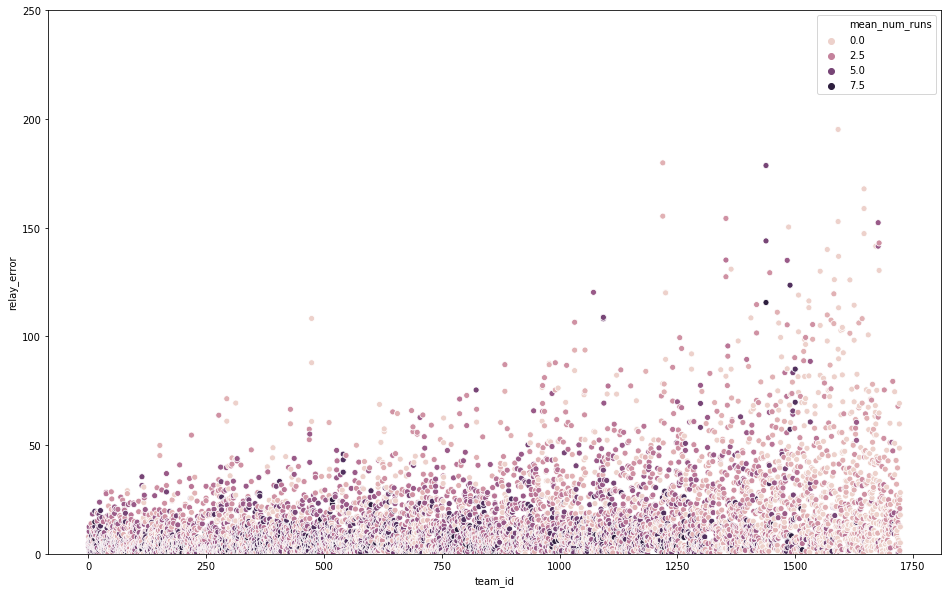

In [34]:
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="team_id", y="relay_error", hue="mean_num_runs", data=with_result)
plot.axes.set_ylim(0, 250)

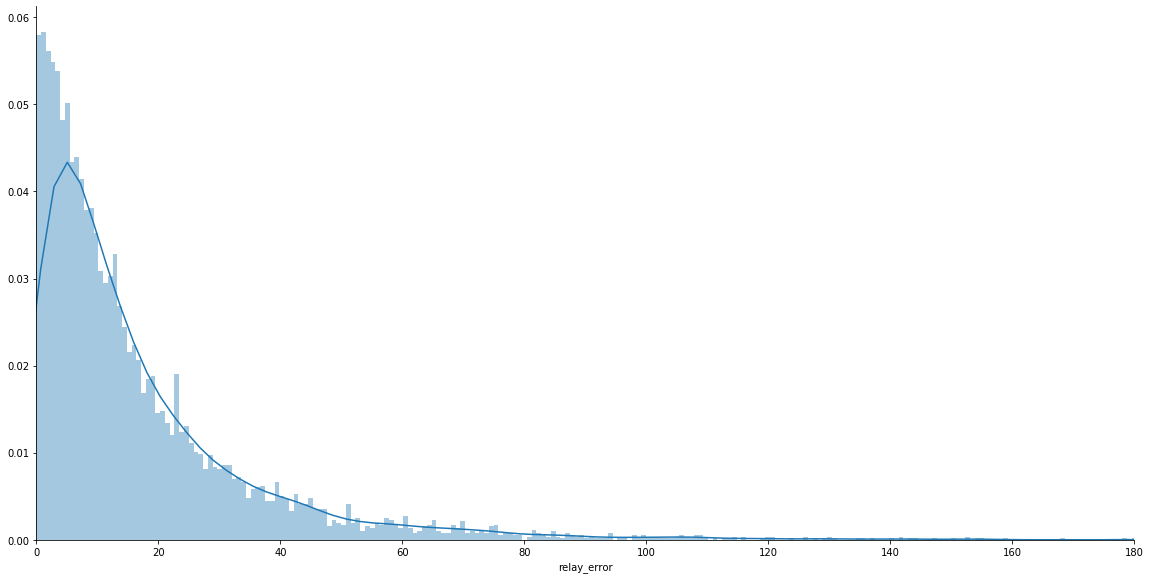

In [35]:
g = sns.FacetGrid(with_result, hue="leg", height=8, aspect=2, xlim=(0,180), margin_titles=True, despine=True)
sns.distplot(with_result.relay_error, bins=250, kde=True)

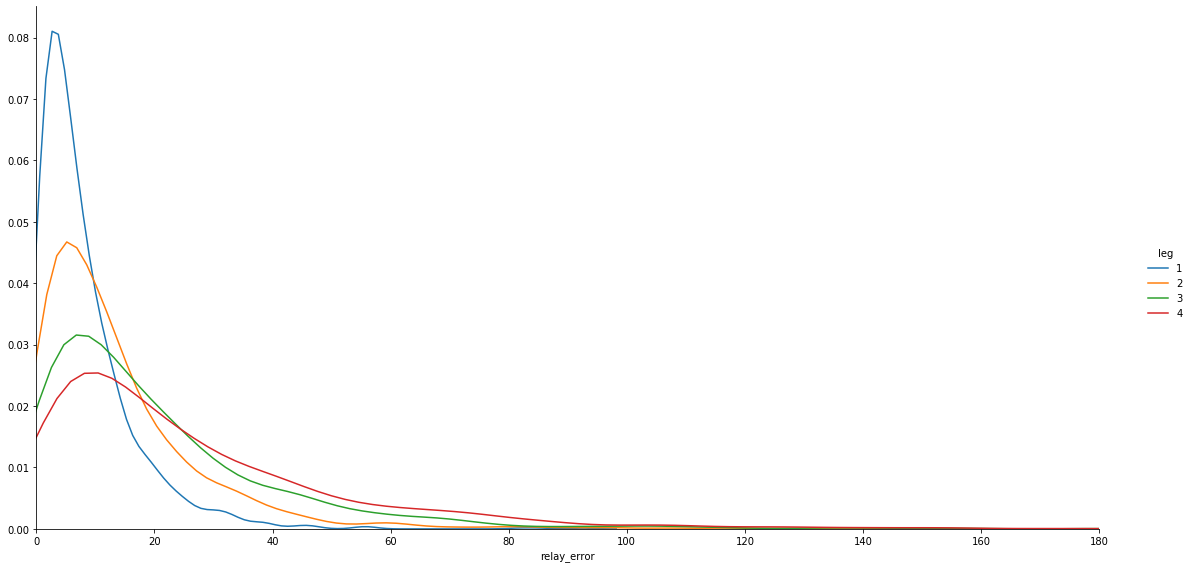

In [36]:
g = sns.FacetGrid(with_result, hue="leg", height=8, aspect=2, xlim=(0,180), margin_titles=True, despine=True)
g.map(sns.distplot, "relay_error", hist=False, hist_kws={'alpha':0.8}).add_legend()

In [37]:
with_result["real_finish_time"] = pd.to_timedelta(with_result["real_relay_time"], unit="min") + shared.start_timestamp[ve_or_ju][year] - pd.to_timedelta(3, unit="hour")
with_result["real_interval_error"] = (with_result["real_finish_time"] < with_result["fin_time_start95"]) | (with_result["real_finish_time"] > with_result["fin_time_end95"])
with_result["real_interval_error_fast"] = (with_result["real_finish_time"] < with_result["fin_time_start95"])
with_result["real_interval_error_slow"] = (with_result["real_finish_time"] > with_result["fin_time_end95"])
np.mean(with_result["real_interval_error"])

display(f'Viestin aikaväliennuste väärin: {np.mean(with_result["real_interval_error"]).round(3) * 100} %')   

'Viestin aikaväliennuste väärin: 8.200000000000001 %'

In [38]:
display(np.mean(with_result["real_interval_error_fast"]))
display(np.mean(with_result["real_interval_error_slow"]))



0.04553042950371832

0.036576111701320385

In [39]:
with_result[["leg", 'real_interval_error', 'real_interval_error_fast', 'real_interval_error_slow']].groupby('leg').agg(["mean"]).round(3)



,real_interval_error,real_interval_error_fast,real_interval_error_slow
,mean,mean,mean
leg,,,
1,0.065,0.022,0.042
2,0.077,0.037,0.040
3,0.080,0.046,0.034
4,0.107,0.077,0.030


In [40]:
with_result[["leg", 'real_interval_error']].groupby('leg').agg(["mean"]).round(3) *100

,real_interval_error
,mean
leg,
1,6.5
2,7.7
3,8.0
4,10.7


In [41]:
with_result[["mean_num_runs", 'real_interval_error', 'real_interval_error_fast', 'real_interval_error_slow']].groupby('mean_num_runs').agg(["mean"]).round(3)

,real_interval_error,real_interval_error_fast,real_interval_error_slow
,mean,mean,mean
mean_num_runs,,,
0.0,0.142,0.068,0.074
1.0,0.091,0.058,0.033
2.0,0.088,0.060,0.028
3.0,0.055,0.033,0.022
4.0,0.065,0.038,0.026
5.0,0.060,0.020,0.040
6.0,0.047,0.019,0.028
7.0,0.018,0.000,0.018


(30, 1200)

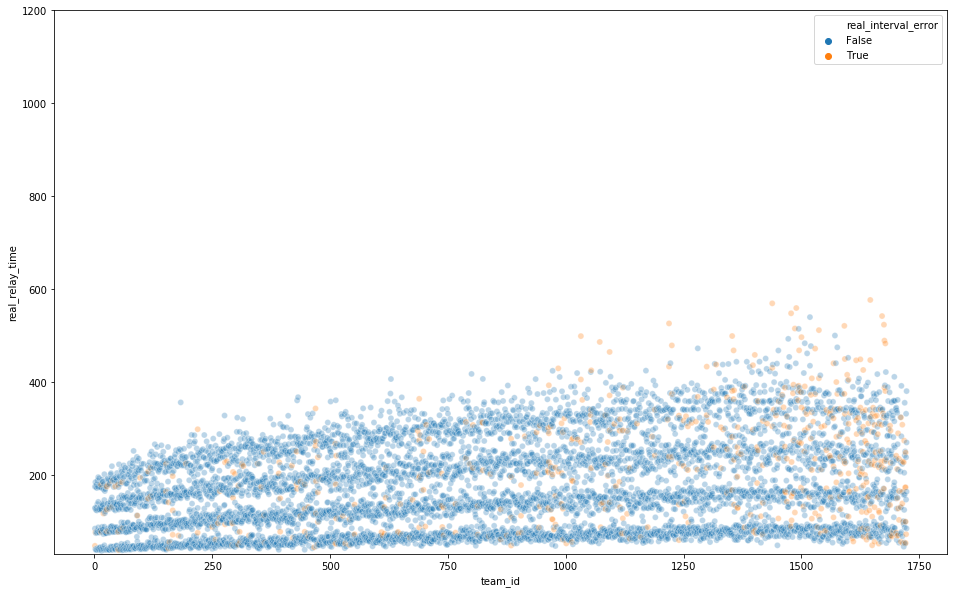

In [42]:
#out_of_interval = with_result[with_result["real_interval_error"]]
plt.figure(figsize=(16, 10))
plot = sns.scatterplot(x="team_id", y="real_relay_time", hue="real_interval_error", alpha=0.3, data=with_result)
plot.axes.set_ylim(30, 1200)

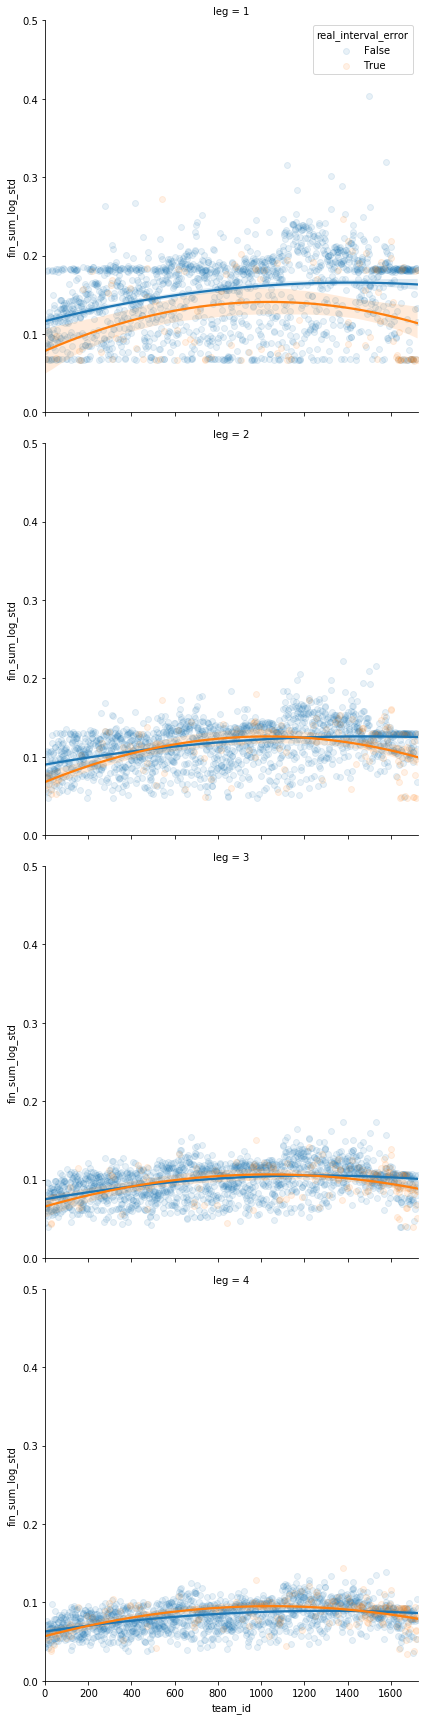

In [43]:
g = sns.FacetGrid(with_result, row="leg", hue="real_interval_error", xlim=(0,with_result.team_id.max()), ylim=(0,0.5), height=6, aspect=1, legend_out=False)
g.map(sns.regplot, "team_id", "fin_sum_log_std", scatter_kws={'alpha':0.1}, order=2).add_legend()
